In [2]:
# I went on Kaggle and found a fun dataset of books, authors, and ratings here: 
# https://www.kaggle.com/jealousleopard/goodreadsbooks
# Thanks @jealousleopard !

library(ggplot2)
library(dplyr)
library(stringr)
library(gender)
library(genderdata)
options(warn = -1) # i would normally not do this but the output was simply too ugly with all the warnings and none of the warnings were anything unexpected


PATH = 'books.csv'

In [3]:
clean.csv <- function(path = PATH) {
    # the original data types are a little wonky (i.e. average_rating and num_pages are character types, not numeric)

    data <- read.csv(path, stringsAsFactors = FALSE)

    data$average_rating     <- as.numeric(data$average_rating)
    data$num_pages          <- as.numeric(data$X..num_pages)

    return(data)
}

clean.data <- clean.csv(PATH)
print(colnames(clean.data))


 [1] "bookID"             "title"              "authors"           
 [4] "average_rating"     "isbn"               "isbn13"            
 [7] "language_code"      "X..num_pages"       "ratings_count"     
[10] "text_reviews_count" "num_pages"         


In [4]:
head(clean.data)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,X..num_pages,ratings_count,text_reviews_count,num_pages
,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>
1,1,Harry Potter and the Half-Blood Prince (Harry Potter #6),J.K. Rowling-Mary GrandPré,4.56,0439785960,9780439785969,eng,652,1944099,26249,652
2,2,Harry Potter and the Order of the Phoenix (Harry Potter #5),J.K. Rowling-Mary GrandPré,4.49,0439358078,9780439358071,eng,870,1996446,27613,870
3,3,Harry Potter and the Sorcerer's Stone (Harry Potter #1),J.K. Rowling-Mary GrandPré,4.47,0439554934,9780439554930,eng,320,5629932,70390,320
4,4,Harry Potter and the Chamber of Secrets (Harry Potter #2),J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272,352
5,5,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),J.K. Rowling-Mary GrandPré,4.55,043965548X,9780439655484,eng,435,2149872,33964,435
6,8,Harry Potter Boxed Set Books 1-5 (Harry Potter #1-5),J.K. Rowling-Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,38872,154,2690


In [6]:
# for the sake of simplicity, let's use a combo of `eng`, `en-US`, and `en-GB`

group.by.author <- function(data) {

    eng.data <- data %>% # here we assume there are no duplicate ISBNs per author
        filter(language_code %in% c('eng', 'en-US', 'en-GB')) %>%
        group_by(authors) %>% 
        summarize(
            count                   = n(),
            mean_average_rating     = median(average_rating, na.rm = FALSE),
            median_num_pages        = median(num_pages, na.rm = FALSE),
            ratings_count           = sum(ratings_count),
            text_reviews_count      = sum(text_reviews_count)
            ) %>%
        arrange(desc(count)) 

    return(eng.data)

}
    
eng.data <- group.by.author(clean.data)
head(eng.data)

authors,count,mean_average_rating,median_num_pages,ratings_count,text_reviews_count
<chr>,<int>,<dbl>,<dbl>,<int>,<int>
Agatha Christie,67,3.910,303.0,1766863,61462
Stephen King,63,3.960,463.0,4156589,89894
Orson Scott Card,46,3.835,354.5,738923,26990
P.G. Wodehouse,42,4.170,272.0,97944,5601
Terry Brooks,37,3.980,435.0,377162,7012
Piers Anthony,34,3.730,342.0,101133,1111


In [7]:
# R has a really cool `gender` data package, which will allow us to look at different general trends amongst reviews, ratings, page counts, prolificness, etc. between male and female authors. Unfortunately, this package doesn't take non-binary or other genders into account, so we can only work with `male` and `female` tags.

gender.bender <- function(data) {

    # get first names of authors
    eng.data$name           <- word(eng.data$authors, 1)
    unique.names            <- unique(eng.data$name)
    unique.genders          <- gender(unique.names)
    
    # match gender data to goodreads authors by first name
    eng.data <- inner_join(eng.data, unique.genders, by = "name")

    return(list(
        men          = filter(eng.data, gender == 'male'),
        women        = filter(eng.data, gender == 'female'),
        eng.gendered = eng.data)
    )
}

authors <- gender.bender(eng.data)
head(authors$eng.gendered)

authors,count,mean_average_rating,median_num_pages,ratings_count,text_reviews_count,name,proportion_male,proportion_female,gender,year_min,year_max
<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Agatha Christie,67,3.910,303.0,1766863,61462,Agatha,0.0000,1.0000,female,1932,2012
Stephen King,63,3.960,463.0,4156589,89894,Stephen,0.9964,0.0036,male,1932,2012
Orson Scott Card,46,3.835,354.5,738923,26990,Orson,1.0000,0.0000,male,1932,2012
Terry Brooks,37,3.980,435.0,377162,7012,Terry,0.8056,0.1944,male,1932,2012
Piers Anthony,34,3.730,342.0,101133,1111,Piers,1.0000,0.0000,male,1932,2012
Margaret Weis-Tracy Hickman,30,3.885,395.5,219974,2545,Margaret,0.0029,0.9971,female,1932,2012


In [8]:
#let's test to see whether there is a different in the average ratings given to male authors vs. female authors

t.test(authors$men$mean_average_rating, authors$women$mean_average_rating)


	Welch Two Sample t-test

data:  authors$men$mean_average_rating and authors$women$mean_average_rating
t = 2.8198, df = 4239.9, p-value = 0.004828
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.008475643 0.047152625
sample estimates:
mean of x mean of y 
 3.927341  3.899527 


In [9]:
# seems like men authors on average get higher reviews than women writers, and this is statstically significant at level alpha = .01
# let's test to see whether there is a different in the avg number of pages written by male vs. female authors

t.test(authors$men$median_num_pages, authors$women$median_num_pages)


	Welch Two Sample t-test

data:  authors$men$median_num_pages and authors$women$median_num_pages
t = 7.7305, df = 4608.5, p-value = 1.307e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 35.40347 59.46162
sample estimates:
mean of x mean of y 
 336.9661  289.5335 


In [8]:
# let's see how prolific our authors really are
quantile(authors$eng.gendered$count, c(.5, .75, .95))

50% 75% 95% 
  1   1   6

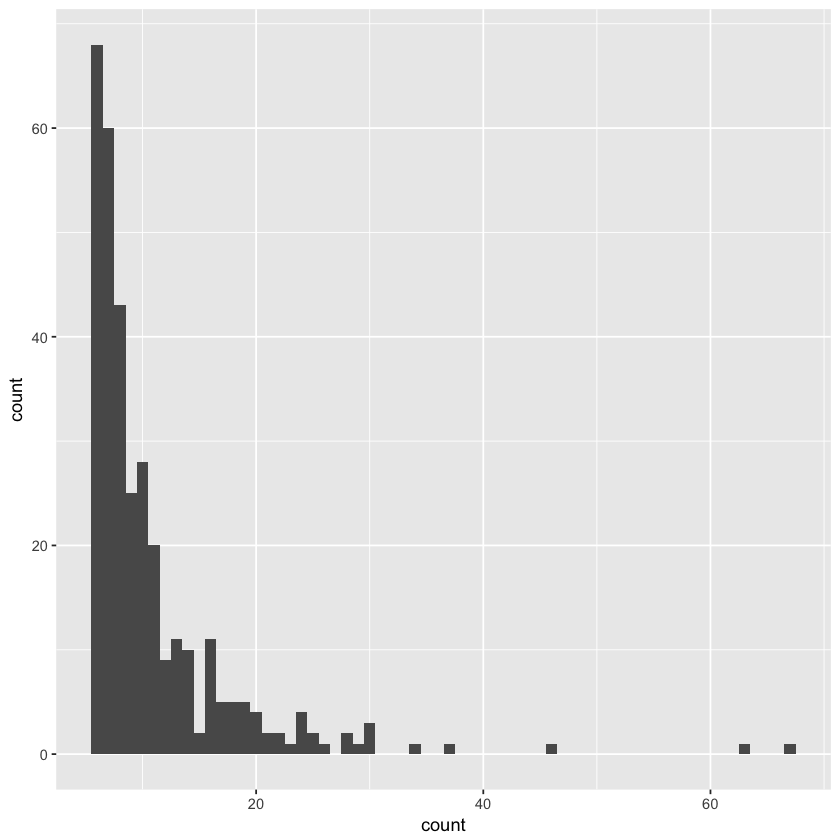

In [48]:
# let's look at the top ~5% of authors in terms of prolificness
prolific <- filter(authors$eng.gendered, count >= 6)
ggplot(prolific, aes(x = count)) + geom_histogram(binwidth = 1)

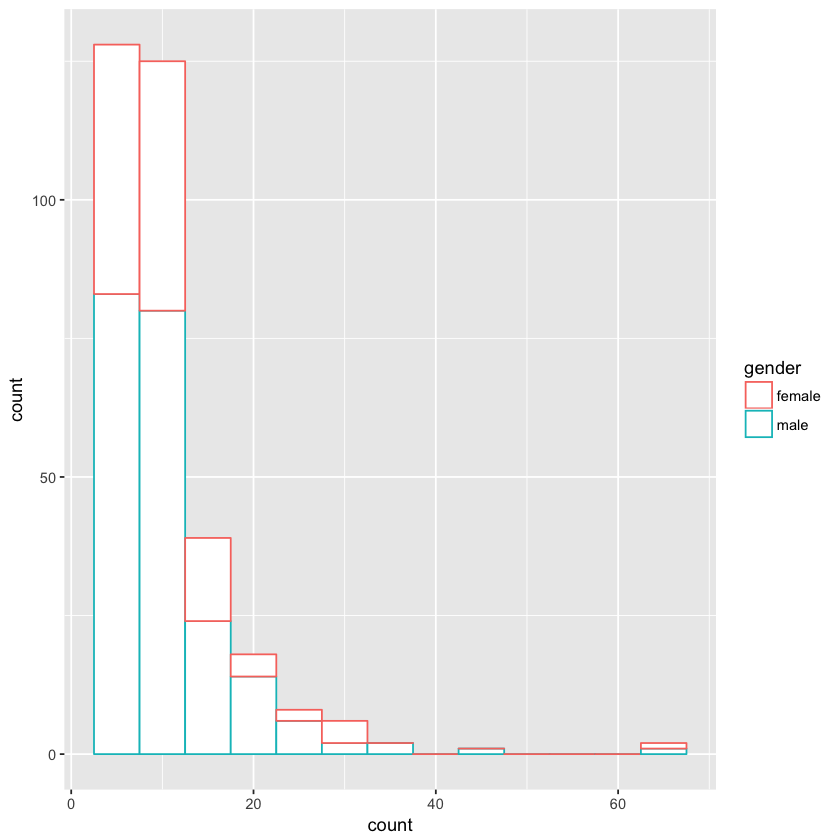

In [51]:
# it appears very few authors write above 40 books in their lifetime
# now let's make a similar histogram yet look at the breakdown by gender simultaneously
ggplot(prolific, aes(x = count, color = gender)) + geom_histogram(fill = "white", binwidth = 5)

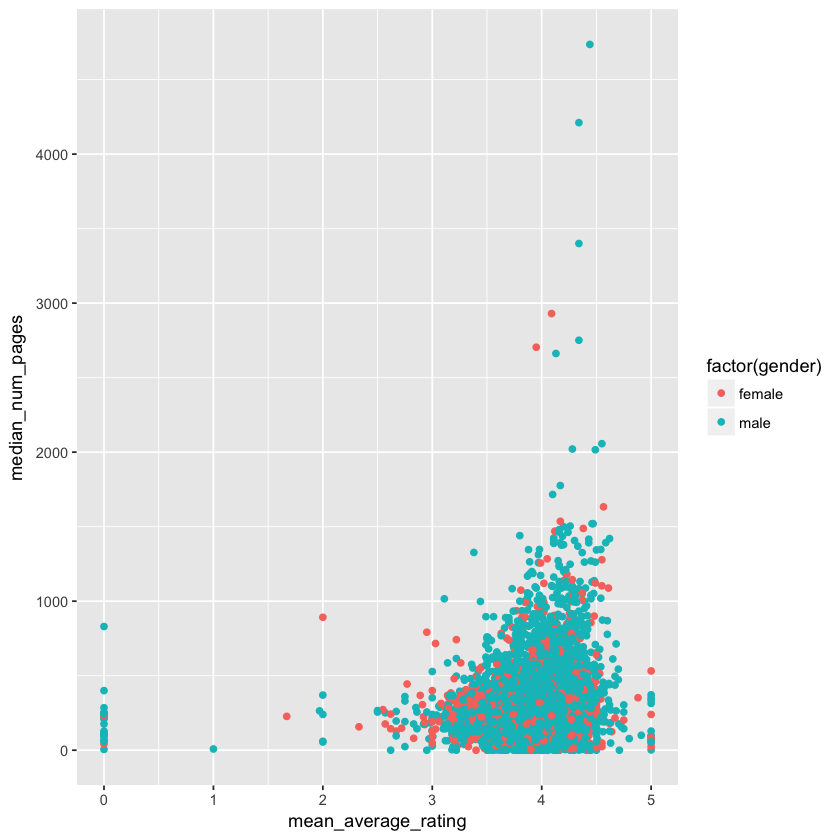

In [13]:
# we're seeing that in the top 5% of prolific writers who have written below 25 or so books, men outwrite women
# let's see if we can see a gender breakdown in the relationship between mean_average_rating and median_num_pages

ggplot(authors$eng.gendered, aes(mean_average_rating, median_num_pages)) + geom_point(aes(color = factor(gender)))

In [ ]:
# though we aren't seeinga gender pattern, we do soo that the median number of pages tends to be between 0-1500 for most authors while the mean average rating tends to be between 3-5